# Fleshed out example

Want to look closer at how the algorithms actually do at finding peaks by **looking at raw tracks** 

#### Imports

In [1]:
from matplotlib import pyplot as plt

import numpy as np

import os
import glob

import pickle
import xarray as xr

from matplotlib import dates
from matplotlib.dates import date2num, num2date

import importlib

### Find modules and  files we will work with

In [2]:
# Load the modules

# Changing directories because we need to be in the directory below the functions
# (may make this a bit neater later..)
os.chdir('/home/oyvindl/work/code/git_public/sigpyproc/examples/')
os.chdir('../')
from sigpyproc import sig_load, sig_append, sig_calc, sig_draft
from sigpyproc import sig_open_water_correction, sig_vel, sig_toolbox, sig_append
os.chdir('examples/')

In [3]:
# Make a list of the .mat files we want to load 
floc = '/media/oyvindl/ratatosk/data/mooring_data/signature500/m1_1/converted/*'
flist = glob.glob(floc)
for fn in flist:
    if '_avgd' in fn:
        flist.remove(fn)

## Load the data 

##### Load from matfiles to a neatly xarray Dataset 

- Wraps from a simgle time dimension to *(TIME, SAMPLE)*
- Concatenates the many .mat files to a single file
- Various formatting stuff
- Calculate tilt
- Estimates sea ice presence from FOM (and adds "sea ice concentration" fields)

Specifying lat/lon here - that can also be done later

This step takes a while (a minute or so?).

Throws some errors that I haven't investigated (don't seem to matter but I don't want to suppress them, until I'm sure what they are)

In [26]:
importlib.reload(sig_load)

<module 'sigpyproc.sig_load' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_load.py'>

In [48]:
DX = sig_load.matfiles_to_dataset(flist, lat = 79.589, lon = 28.097)

/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:270: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(
/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:279: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(


1870992 time points, 38979 ensembles. Sample per ensemble: 48
Done. Run sig_funcs.overview() to print some additional details.


##### Have a quick look at the data 

We can look at the file interactively by just typing "DX".

We can also run *sig_load.overview(DX)* for some very basic statistics.

We can also run *sig_toolbox.histogram(DX, [variable name])* to look at the distribution of a variable 

In [49]:
sig_load.overview(DX)


TIME RANGE:
06 Oct 2018 12:00  -->  16 Nov 2019 12:30  (406.0 days)
Time between ensembles: 15.0 min.
Time between samples in ensembles: 1.0 sec.

PRESSURE:
Median (STD) of altimeter pressure: 20.6 dbar (0.5 dbar)  - with fixed atm offset 9.500 dbar.

SIZE:
Total 1870992 time points.
Split into 38979 ensembles with 48 sample per ensemble.
Ocean velocity bins: 16.


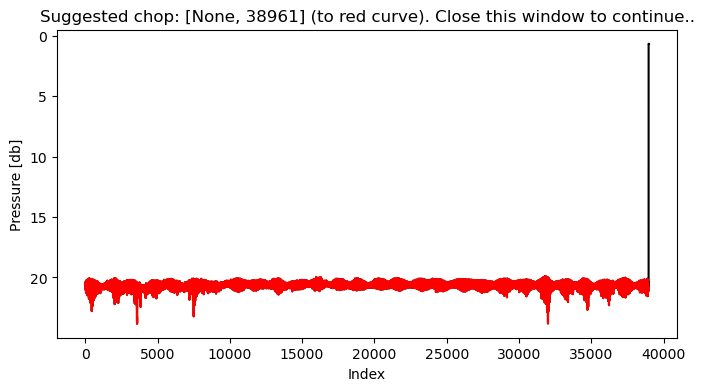

Suggested chop: [None, 38961] (to red curve)
Accept (y/n)?: y
Chopping to index [None, 38961]
Chopped 18 ensembles using -> [None, 38961] (total ensembles 38979 -> 38961)


In [50]:
# Good starting point: Just call the function and follow the prompts. 
DX = sig_load.chop(DX)

We have now chopped away the time on deck durign the recovery, reducing the size of the dataset a bit.

Note that this information is preserved in *DX.history* attribute 

## Look at raw file

In [51]:
importlib.reload(sig_load)

<module 'sigpyproc.sig_load' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_load.py'>

In [121]:
fn_ = flist[8]#14 has weird temp
dx = sig_load._matfile_to_dataset(fn_, include_raw_altimeter=True)[0]
dxtime = sig_calc.mat_to_py_time(dx.time_average)
alt_time = dx.AverageRawAltimeter_Time

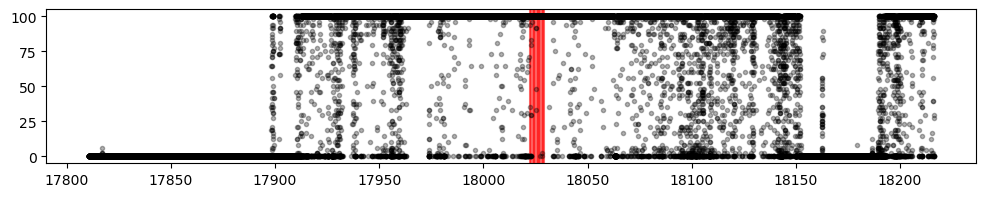

In [122]:
fig0, ax0 = plt.subplots(figsize = (12, 2),)

for alt_time_ in dx.raw_altimeter_time[14:26]:
    ax0.axvline(alt_time_.data, ls = '-', color = 'r', alpha = 0.6)
ax0.plot(DX.TIME, DX.SIC_FOM, '.k', alpha = 0.3)

#ax0.set_xlim(dx.raw_altimeter_time[0], dx.raw_altimeter_time[-1])

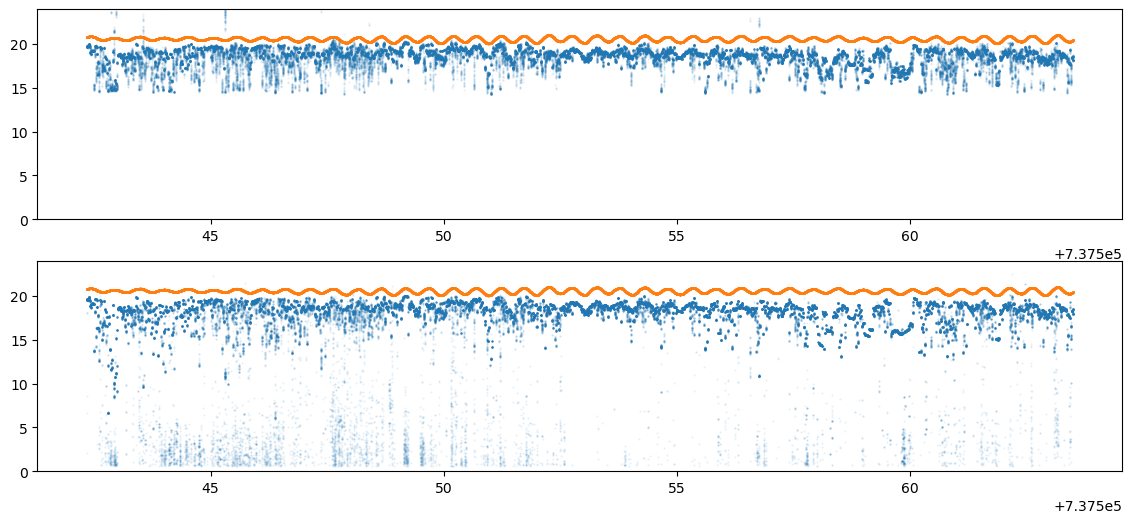

In [123]:
fig, ax = plt.subplots(2, 1, figsize = (14, 6))
ax[0].plot(dx.Average_Time, dx.Average_AltimeterDistanceAST, '.', ms=1, alpha = 0.1)
ax[0].plot(dx.Average_Time, dx.Average_AltimeterPressure, '.', ms=1, alpha = 0.1)
ax[1].plot(dx.Average_Time, dx.Average_AltimeterDistanceLE, '.', ms=1, alpha = 0.1)
ax[1].plot(dx.Average_Time, dx.Average_AltimeterPressure, '.', ms=1, alpha = 0.1)
for axn in ax:
    axn.set_ylim(0, 24)

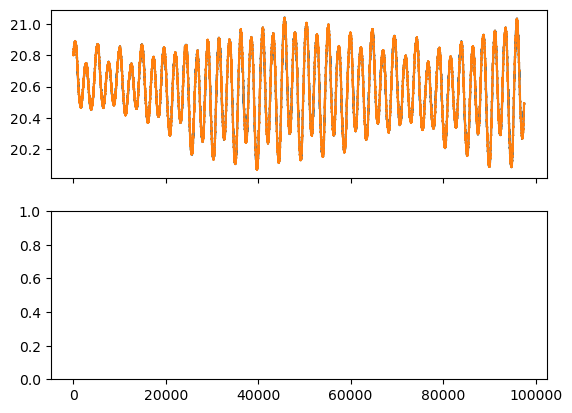

In [124]:
fig, ax = plt.subplots(2, 1, sharex = True)
ax[0].plot(dx.Average_AltimeterPressure) 
ax[0].plot(dx.Average_Pressure)

(17.0, 21.0)

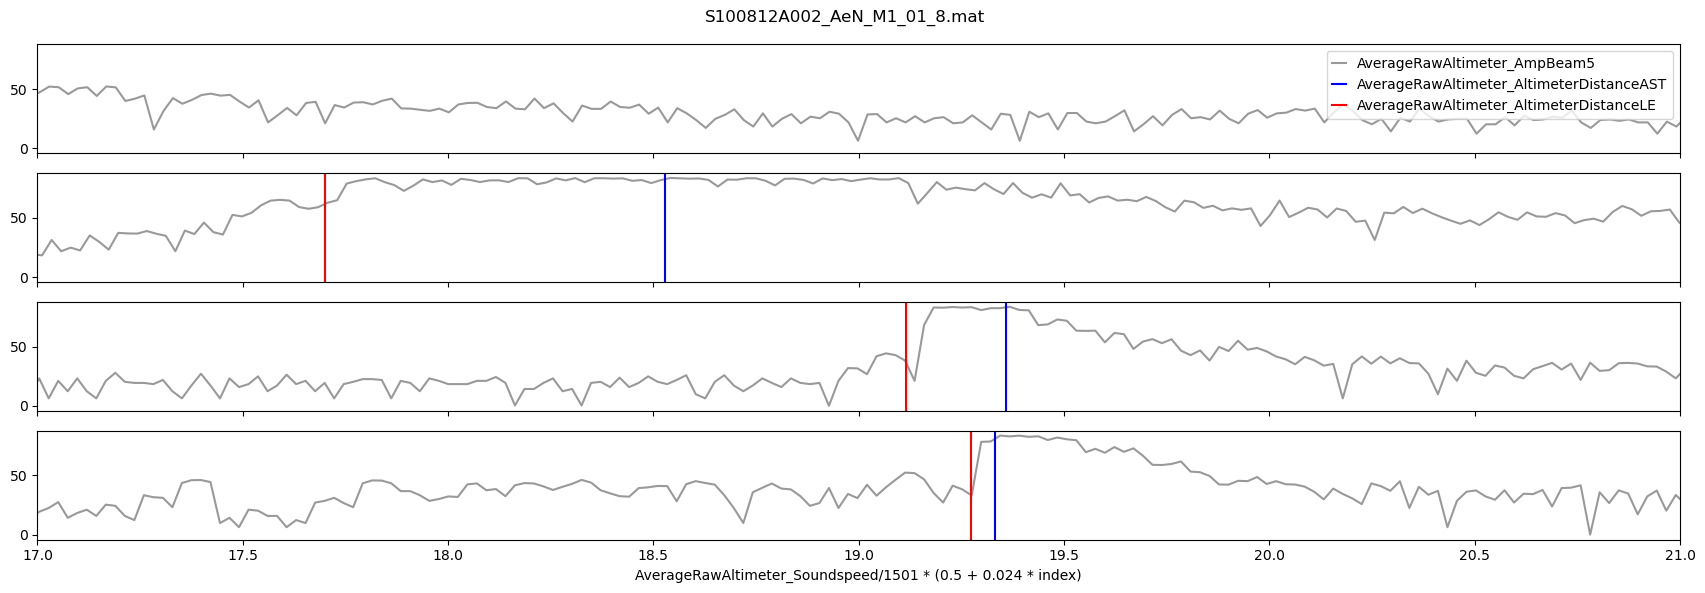

In [146]:

Nfigs = 4
fig, ax = plt.subplots(Nfigs, 1, sharex = True, figsize = (17, 6),)

fixed_ss = 1501
ss_fact = dx.AverageRawAltimeter_Soundspeed/fixed_ss

distance_from_head =0.5+0.024*(1+dx.along_altimeter)

use_ss_scaled = True

xlabel = '0.5 + 0.024 * index'
if use_ss_scaled:
    distance_from_head = distance_from_head*ss_fact
    xlabel = 'AverageRawAltimeter_Soundspeed/%.0f * (0.5 + 0.024 * index)'%fixed_ss

for nn in np.arange(Nfigs):
    alt_nn = nn + 14
    if use_ss_scaled:
        ax[nn].plot(distance_from_head.isel(time_raw_altimeter=alt_nn), 
                dx.AverageRawAltimeter_AmpBeam5.isel(time_raw_altimeter=alt_nn), 'k', 
                alpha = 0.4, label = 'AverageRawAltimeter_AmpBeam5')
    else:
        ax[nn].plot(distance_from_head, 
                dx.AverageRawAltimeter_AmpBeam5.isel(time_raw_altimeter=alt_nn), 'k', 
                alpha = 0.4, label = 'AverageRawAltimeter_AmpBeam5')
    ax[nn].axvline(dx.AverageRawAltimeter_AltimeterDistanceAST.isel(time_raw_altimeter=alt_nn),
                   color = 'b', label = 'AverageRawAltimeter_AltimeterDistanceAST')
    ax[nn].axvline(dx.AverageRawAltimeter_AltimeterDistanceLE.isel(time_raw_altimeter=alt_nn), 
                   color = 'r', label = 'AverageRawAltimeter_AltimeterDistanceLE')


    #ax[nn].set_ylabel('LE Q: %s\nAST Q: %s'%(
    #    dx.Average_AltimeterQualityLE[nn].data, dx.Average_AltimeterQualityAST[nn].data))
ax[-1].set_xlabel(xlabel)
ax[0].legend(fontsize = 10, ncol = 1, handlelength = 1, loc = 1)
fig.suptitle('%s'%(fn_.replace(floc[:-1], '')))
plt.tight_layout()

#ax[0].set_xlim(3, 6)

#ax[0].set_xlim(19, 20)
ax[0].set_xlim(17, 21)

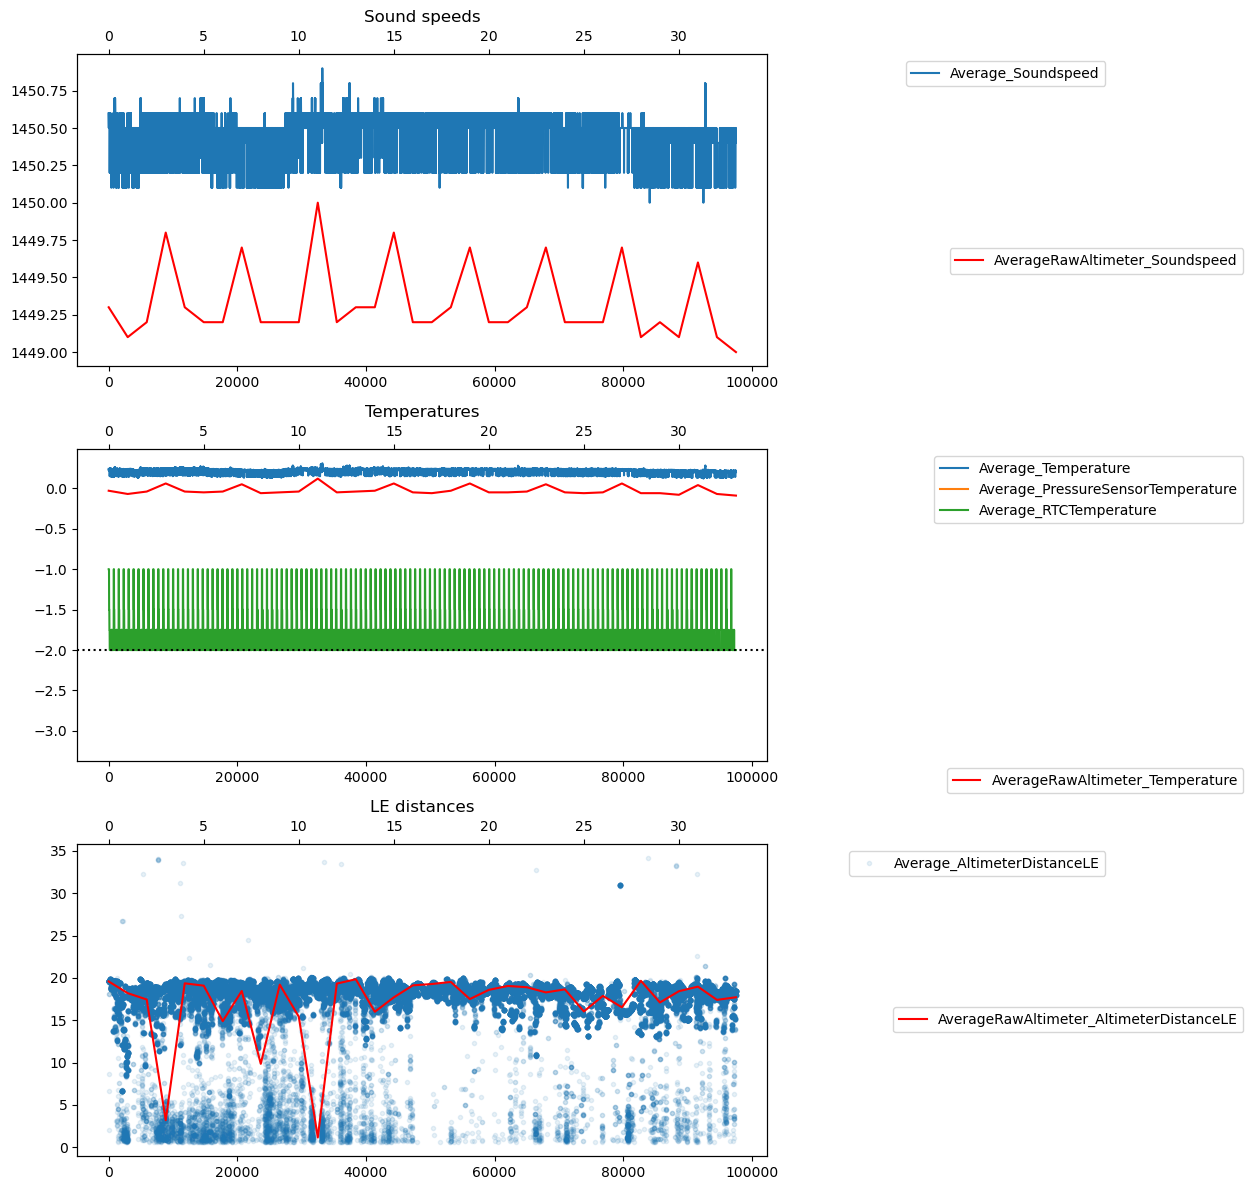

In [126]:
fig,ax = plt.subplots(3, 1, figsize = (8, 12))
ax[0].plot(dx.Average_Soundspeed, label='Average_Soundspeed')

twinax = ax[0].twiny()
twinax.plot(dx.AverageRawAltimeter_Soundspeed, 'r', label = 'AverageRawAltimeter_Soundspeed')

ax[1].plot(dx.Average_Temperature, label='Average_Temperature')
ax[1].plot(dx.Average_PressureSensorTemperature, label='Average_PressureSensorTemperature')
ax[1].plot(dx.Average_RTCTemperature, label='Average_RTCTemperature')

twinax2 = ax[1].twiny()
twinax2.plot(dx.AverageRawAltimeter_Temperature, 'r', label='AverageRawAltimeter_Temperature')
#ax[1].plot(DX.AverageRawAltimeter_Soundspeed.mean('SAMPLE'), label='Average_PressureSensorTemperature')


ax[2].plot(dx.Average_AltimeterDistanceLE, '.', alpha = 0.1, label='Average_AltimeterDistanceLE')

twinax3 = ax[2].twiny()
twinax3.plot(dx.AverageRawAltimeter_AltimeterDistanceLE, 'r', label='AverageRawAltimeter_AltimeterDistanceLE')

ax[0].set_title('Sound speeds')
ax[1].set_title('Temperatures')
ax[2].set_title('LE distances')


plt.tight_layout()

ax[0].legend(bbox_to_anchor = (1.5, 1))
twinax.legend(bbox_to_anchor = (1.7, 0.4))
ax[1].legend(bbox_to_anchor = (1.7, 1))
twinax2.legend(bbox_to_anchor = (1.7, 0))
ax[2].legend(bbox_to_anchor = (1.5, 1))
twinax3.legend(bbox_to_anchor = (1.7, 0.5))
ax[1].axhline(-2, color = 'k', ls = ':')
#ax.set_ylim(25, 18)

### Questions for me
- Which temperature matches the RBRs best?


### Questions for Nortek

- Are they *sure* that 0.5+0.24*x is the correct formula?
- IF NOT: Why don't these line up better? (the difference is dramatic - around a meter!)
- **DO I NEED TO APPLY A CORRECTION FACTOR TO ANYTHING HERE?**
- **HOW ARE THESE THINGS ACTUALLY CALCULATED? WHAT SOUND SPEEDS GO WHERE?**

*Note: This is before the pressure does anything, so is can probably only be altimeter and/or sound speed*

- *(Is this with a "raw/nominal" sound speed?)*

Confirm that I am reading the right fields:
- *Average_AltimeterDistanceAST/Average_AltimeterDistanceLE*
- *Average_VelNorth*..
- *Average_VelEast*..

Other:
- What are the *AltimeterQuality* parameters ? Seem a bit arbitrary.

In [ ]:
dx.Average_AltimeterDistanceAST